In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
from statsmodels.stats.weightstats import ztest
import scanpy as sc
import anndata
import warnings 
warnings.filterwarnings("ignore")


In [2]:
### HELPER FUNCTIONS ###

def fraction_test(df_expression, FEATURE, gene, cell_type):
    # return pval
    df_expression['is_expressing'] = df_expression.exp >2.5
    values_in_feature = list(set(df_expression[FEATURE]))
    if len(values_in_feature) < 2:
        print(f'no cells in one of the groups for: {gene}, {cell_type}')
        return 1
    val_1 = values_in_feature[0]
    val_2 = values_in_feature[1]
    
    if len(df_expression[df_expression[FEATURE]==val_1])<=5 or len(df_expression[df_expression[FEATURE]==val_2])<=5:
        return 1
    fractions = df_expression.groupby(['sample', FEATURE])['is_expressing'].agg(['sum', 'count']).reset_index()
    fractions['fractions'] = fractions['sum']/fractions['count']
    statistic, pvalue = ranksums(fractions[fractions[FEATURE]==val_2].fractions, fractions[fractions[FEATURE]==val_1].fractions)
    return pvalue

def Z_TEST(df_expression, FEATURE, gene, cell_type):
    # return pval
    values_in_feature = list(set(df_expression[FEATURE]))
    if len(values_in_feature) < 2:
        print(f'no cells in one of the groups for: {gene}, {cell_type}')
        return 1
    val_1 = values_in_feature[0]
    val_2 = values_in_feature[1]
    
    if len(df_expression[df_expression[FEATURE]==val_1])<=5 or len(df_expression[df_expression[FEATURE]==val_2])<=5:
        return 1
    statistic, pvalue = ztest(res_df[df_expression[FEATURE]==val_1].exp, df_expression[res_df[FEATURE]==val_2].exp, value=0) 
    return pvalue

def fisher_test(df_expression, FEATURE, gene, cell_type):

    df_expression['is_expressing'] = df_expression.exp >2.5
    values_in_feature = list(set(df_expression[FEATURE]))
    if len(values_in_feature) < 2:
        print(f'no cells in one of the groups for: {gene}, {cell_type}')
        return 1
    val_1 = values_in_feature[0]
    val_2 = values_in_feature[1]

    
    if len(df_expression[df_expression[FEATURE]==val_1])<=5 or len(df_expression[df_expression[FEATURE]==val_2])<=5:
        return 1

    n_cells_expressing = df_expression.groupby(FEATURE)['is_expressing'].sum()
    n_cells = df_expression.groupby(FEATURE)['is_expressing'].count()

    R_n_cells_expressing = n_cells_expressing[val_1]
    NR_n_cells_expressing = n_cells_expressing[val_2]
    R_n_cells_not_expressing = n_cells[val_1] - R_n_cells_expressing
    NR_n_cells_not_expressing = n_cells[val_2] - NR_n_cells_expressing

    import scipy.stats as stats
    oddsratio, pvalue = stats.fisher_exact([[R_n_cells_expressing, NR_n_cells_expressing],
                                            [R_n_cells_not_expressing, NR_n_cells_not_expressing]])
    return pvalue

# The rule is * for p<0.05, ** for p<0.005 and *** for p<0.0005.

def get_pval_symbol(p):
    if p<0.0005:
        return '***'
    elif p<0.005:
        return '**'
    elif p<0.05:
        return '*'
    else:
        return ''

In [3]:
data_path = r'/storage/md_keren/shitay/Data/smart_seq/SmartSeq_RNAseq_DATA.p'
cells, gene_names, patients_information = extract_smart_seq_data_from_pickle(data_path)

from utilities.smart_seq_dataset import RNAseq_Dataset
cohort = RNAseq_Dataset(cells, patients_information, gene_names)

### Prob: TNFA appears as TNF

genes = ['CCR8',  'CXCR3', 'CCL1', 'CXCL11', 'CXCL10', 'CXCL9', 'IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']
gene_indices = [cohort.gene_names.index(gg) for gg in genes]

from anndata import AnnData
annCohort = AnnData(cohort.cells)

annCohort.var['gene'] = cohort.gene_names

annCohort.obs['sample'] = [cell.patient_details for cell in cohort.cells_information_list] 
annCohort.obs['barcode'] = [cell.cell_id for cell in cohort.cells_information_list] 
annCohort.obs['cell_type'] = [cell.supervised for cell in cohort.cells_information_list] 
annCohort.obs['response'] = [cell.response for cell in cohort.cells_information_list] 
annCohort.obs['pre/post'] = [p.split('_')[0] for p in annCohort.obs['sample'].values.tolist()]

### Mark cells as CD103+ is they express CD103
MIN_EXP_THRESHOLD = 2.5
CD103_index = annCohort.var.gene.tolist().index('ITGAE') #.index('CD103')
annCohort.obs['CD103+'] = annCohort.X[:,CD103_index] > MIN_EXP_THRESHOLD

### Mark cells as myeloid if their cell type is myeloid
MYELOID_CELL_TYPES = ['Macrophage_immature', 'Macrophage_mature', 'Monocyte_immature', 'Monocyte_mature', 'cDCs_dendritic_cells', 
 'pDCs', 'myeloid cells_general_immature', 'myeloid cells_general_mature', 'Neutrophils', 'Granolocytes']
def is_overlap(l1 , l2):
    return len([f for f in l1 if f in l2])!=0
annCohort.obs['is_myeloid'] = annCohort.obs['cell_type'].apply(lambda x: is_overlap(x, MYELOID_CELL_TYPES))


### Update cell type list
def add_pos_CD103_in_df(x):
    if x['CD103+'] and x['is_myeloid']:
        return x['cell_type'] + ['CD103+']
    else:
        return x['cell_type'] 

annCohort.obs['cell_type'] = annCohort.obs.apply(lambda x: add_pos_CD103_in_df(x), axis=1)

cell_types = list(set(flatten_list(annCohort.obs['cell_type'].tolist())))
t_cell_types = [ct for ct in cell_types if 'T' in ct]
not_t_cell_types = [ct for ct in cell_types if not ct in t_cell_types]

# 1. More customized run

In [4]:
# CELL_TYPES = ['T cells', 'Activated T cells', 'CD8 Cytotoxic T cells', 'Regulatory T cells', 'CD4 helper T cells']
# genes = ['CXCR3', 'CCL1'] #, 'CXCL11', 'CXCL10', 'CXCL9', 'IFNG', 'TNF', 'GZMB', 'PRF1', 'IL2']
CELL_TYPES = ['cDCs_dendritic_cells', 'Macrophage_mature','Monocyte_mature','Neutrophils']
genes = ['CXCL9', 'CXCL10', 'CXCL11']

FEATURE = 'response' # 'pre/post' | 'response'
filter_type = 2


################################## TEST_NAME ##################################
# TEST_NAME='Fraction'
# stat_test = fraction_test
TEST_NAME='FISHER'
stat_test = fisher_test
######################
# fig_size_inches = (10, 6)
# fig_size_inches = (8, 4)
font_size = 16

gonna filter pre/post
took only Post samples
cohort for comparison details:
View of AnnData object with n_obs × n_vars = 10363 × 20214
    obs: 'sample', 'barcode', 'cell_type', 'response', 'pre/post', 'CD103+', 'is_myeloid'
    var: 'gene'


NameError: name 'fig_size_inches' is not defined

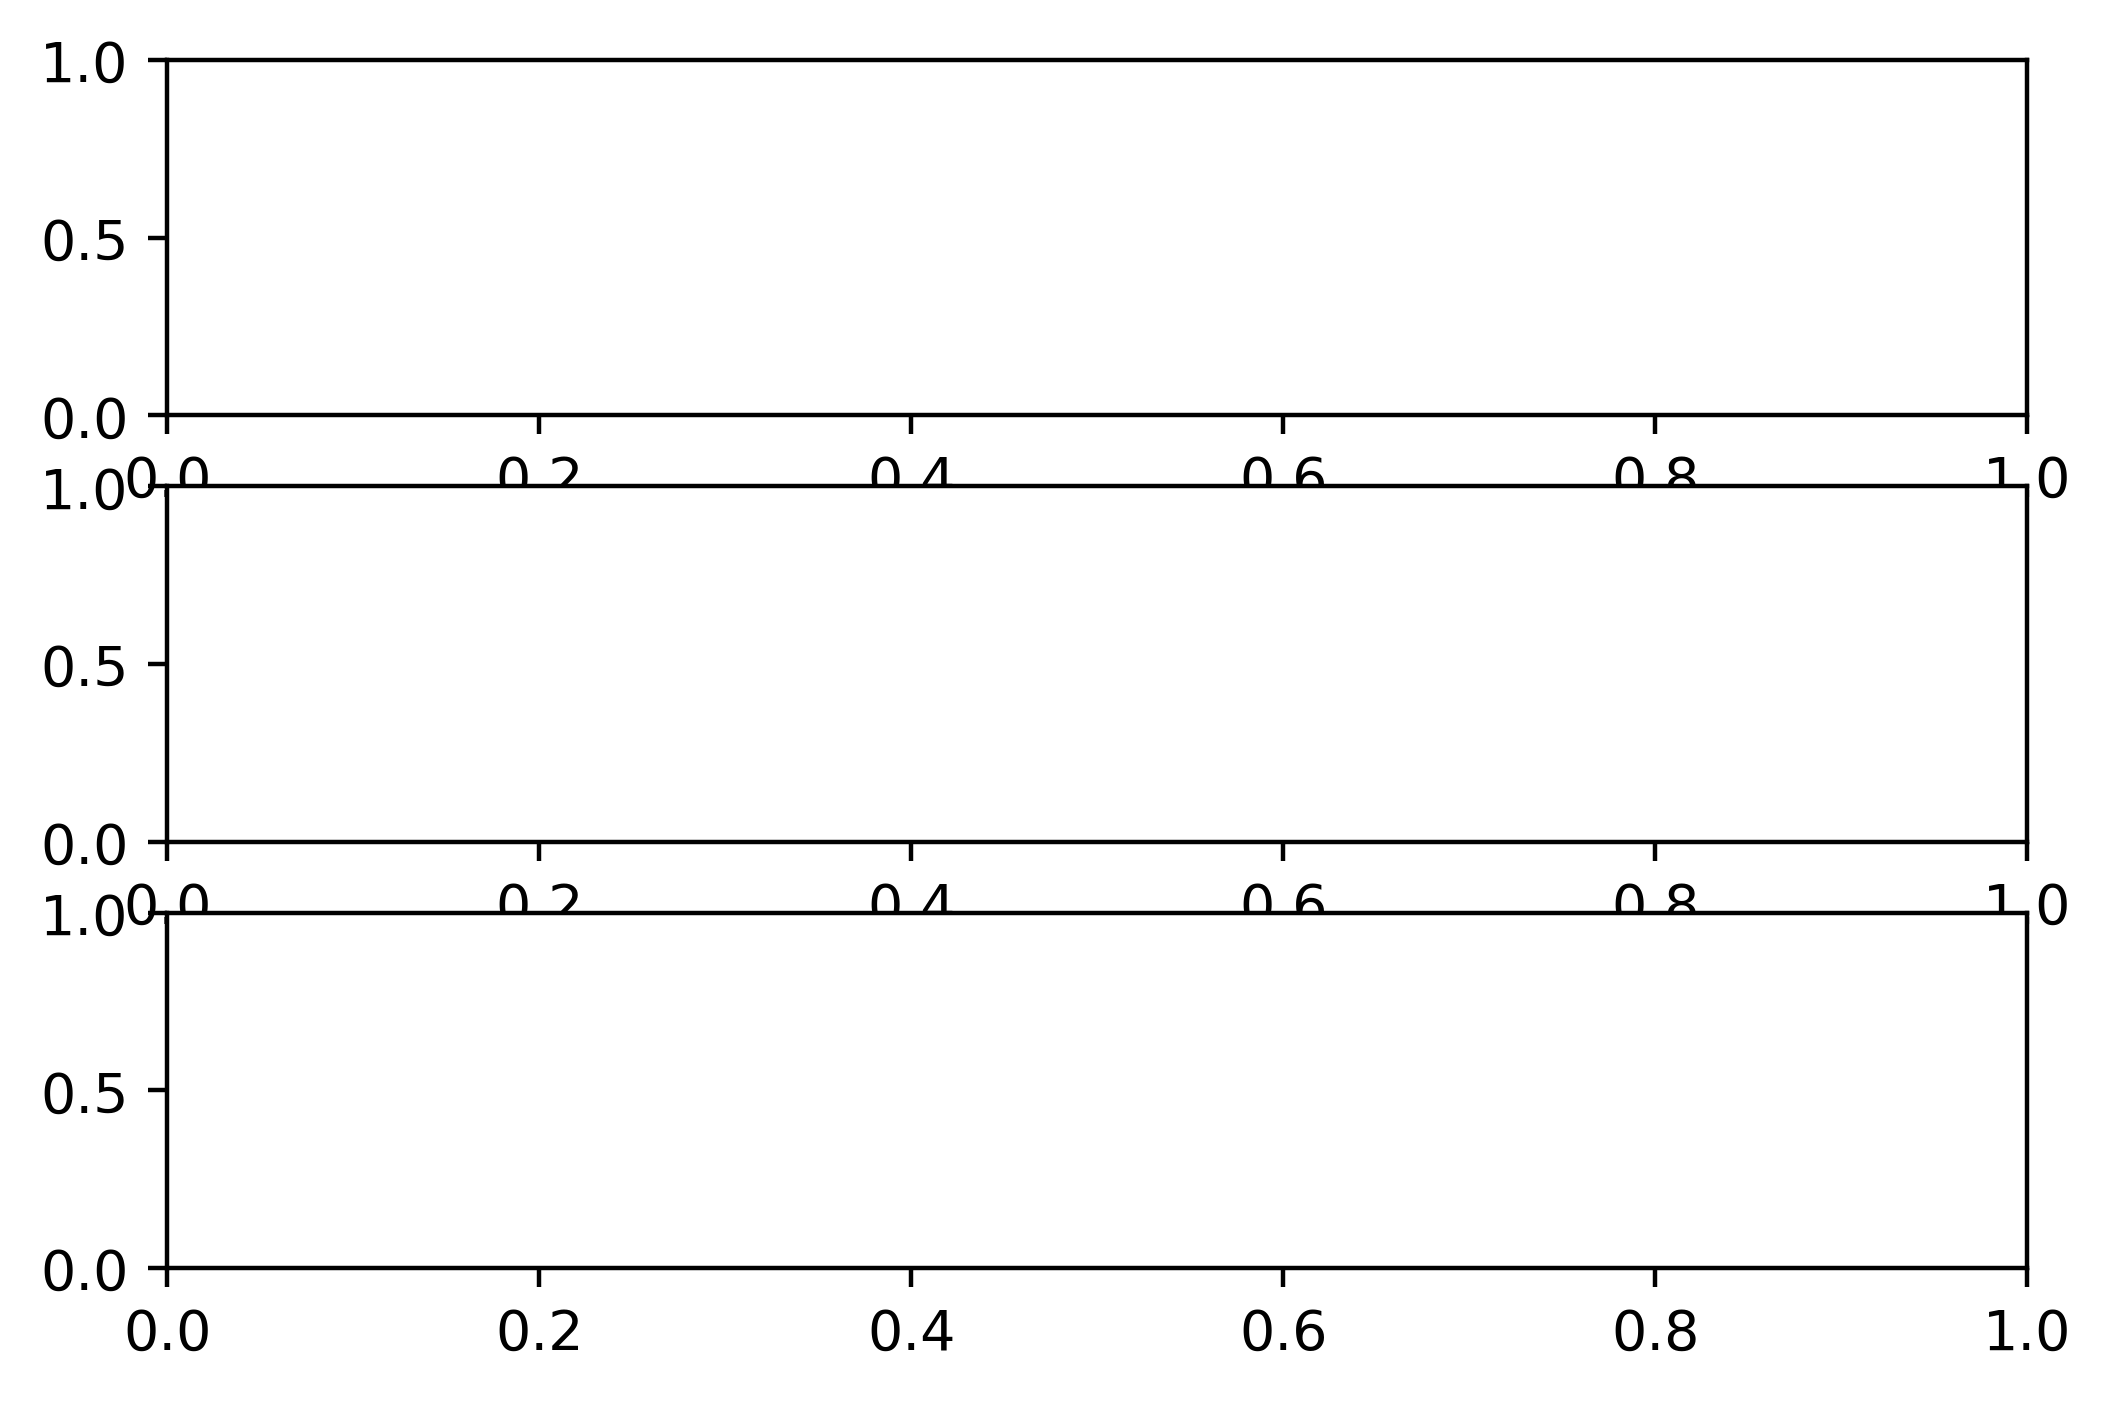

In [5]:
### builds DFs of all genes X cell types and conduct Z test:
# fig_size_inches = (32, 30)
# font_size = 32


################################## Filter type ##################################
filter_dic = {'response': {1: 'Responder', 2: 'Non-responder'}, 'pre/post': {1: 'Pre', 2:'Post'}}
filter_feature_dic = {'response': 'pre/post', 'pre/post': 'response'} # take by reverse

filtered_cohort = annCohort
if filter_type:
    FILTER_FEATURE = filter_feature_dic[FEATURE]
    print(f'gonna filter {FILTER_FEATURE}')
    filter_feature_req_value = filter_dic[FILTER_FEATURE][filter_type]
    filtered_cohort = annCohort[annCohort.obs[FILTER_FEATURE] == filter_feature_req_value]
    print(f'took only {filter_feature_req_value} samples')

else:
    print(f'did not filter')
print(f'cohort for comparison details:')
print(filtered_cohort)


################################## TO_TEST_T_CELLS ##################################
df_fractions = pd.DataFrame(columns=['sample', 'response', 'fraction', 'gene', 'cell_type'])
pvals = {}
for gene_idx, gene in enumerate(genes):
    gene_cohort = filtered_cohort[:,  filtered_cohort.var['gene']==gene]
    for idx, cell_type in enumerate(CELL_TYPES):
        cell_type_indices = [cell_type in ttt for ttt in gene_cohort.obs['cell_type']]
        cell_type_cohort = gene_cohort[cell_type_indices, :]
        
        gene_exps = cell_type_cohort.X[:,0].tolist()
        res_df = pd.DataFrame(np.concatenate((cell_type_cohort.obs[['sample', FEATURE]].values.T,[gene_exps])).T, columns=['sample', FEATURE, 'exp'])
        
        ### statistical test of gene expression R/NR
        pvalue = stat_test(res_df, FEATURE, gene, cell_type)
        pvals[(gene, cell_type)] = pvalue
        
        sample_fraction_df = pd.DataFrame(res_df.groupby(['sample', FEATURE]).sum()['is_expressing'] / res_df.groupby('sample').count()['is_expressing']).reset_index().rename(columns={'is_expressing': 'fraction'})
        sample_fraction_df['gene'] = gene
        sample_fraction_df['cell_type'] = cell_type
        df_fractions = df_fractions.append(sample_fraction_df)

# Correct pvals
pvals_arr = np.array([[k, v] for k,v in list(pvals.items())])
corrected_pvals = pvals_arr.copy()
corrected_pvals[:,1] = multipletests_fdr(pvals_arr[:,1])[1].tolist()
corrected_pvals = {pp[0]: pp[1] for pp in corrected_pvals}

# Prints using sns
fig, axs = plt.subplots(len(genes))
fig.set_size_inches(fig_size_inches)
def get_coorected_label(x ,p_value_dic):
    pvalue = p_value_dic[(x['gene'], x['cell_type'])]
    return x['cell_type'] + '\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if pvalue < sig])
df_fractions['Cell_type'] = df_fractions.apply(lambda x: get_coorected_label(x, corrected_pvals), axis=1)

hue_order = {'pre/post': [ "Pre", "Post"],
             'response': ["Non-responder", "Responder"]}
for gene_idx, gene in enumerate(genes):
        df_fractions_cur_gene = df_fractions[df_fractions['gene'] == gene]
        sns.boxplot(ax=axs[gene_idx], x='Cell_type', y='fraction', hue=FEATURE, hue_order = hue_order[FEATURE],
                    data=df_fractions_cur_gene, palette={"Responder": "b", "Non-responder": "r", "Pre":"r", "Post":"b"}).set(title=gene);
        sns.stripplot(ax=axs[gene_idx], x='Cell_type', y='fraction', data=df_fractions_cur_gene, hue=FEATURE, hue_order = hue_order[FEATURE],
                  jitter=True, dodge=True, alpha=0.3,linewidth=0.5, palette={"Responder": "b", "Non-responder": "r", "Pre":"r", "Post":"b"});
        if not (gene_idx==0): axs[gene_idx].legend_ = None

if filter_type:
    fig.suptitle(f'Comparing {FEATURE}, only \'{filter_feature_req_value}\' samples were taken', fontsize=font_size)
else:
    fig.suptitle(f'Comparing {FEATURE}', fontsize=font_size)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 2. Only set output dir and all combination of experiments will be run and be saved there:

In [4]:
OUTPUT_FOLDER = r'/storage/md_keren/shitay/Nathi_project/differential analysis/20.12.21'

combinations = [[c1, c2, c3, c4] for c1 in ['FISHER', 'FRACTION'] for c2 in ["response", "pre/post"] for c3 in [None, 1,2] for c4 in [True, False]]
create_folder(OUTPUT_FOLDER)

In [ ]:
for c_idx, comb in enumerate(combinations):
    print(f'\n######################################################################################################')
    print(f'Working on {comb} ({c_idx+1}/{len(combinations)})')
    TEST_NAME = comb[0] # FRACTION/Z/FISHER
    FEATURE = comb[1] # "response" or "pre/post"
    filter_type = comb[2]
    TO_TEST_T_CELLS = comb[3] # True - t cells \ False - not t cells - all other
    ################################## TEST_NAME ##################################
    if TEST_NAME=='FRACTION':
        stat_test = fraction_test
    elif TEST_NAME=='Z':
        stat_test = Z_TEST
    elif TEST_NAME=='FISHER':
        stat_test = fisher_test
    else:
        raise Exception('statistical name is not valid, change it')


    ################################## Filter type ##################################
    filter_dic = {'response': {1: 'Responder', 2: 'Non-responder'}, 'pre/post': {1: 'Pre', 2:'Post'}}
    filter_feature_dic = {'response': 'pre/post', 'pre/post': 'response'} # take by reverse

    filtered_cohort = annCohort
    if filter_type:
        FILTER_FEATURE = filter_feature_dic[FEATURE]
        print(f'gonna filter {FILTER_FEATURE}')
        filter_feature_req_value = filter_dic[FILTER_FEATURE][filter_type]
        filtered_cohort = annCohort[annCohort.obs[FILTER_FEATURE] == filter_feature_req_value]
        print(f'took only {filter_feature_req_value} samples')

    else:
        print(f'did not filter')
    print(f'cohort for comparison details:')
    print(filtered_cohort)


    ################################## TO_TEST_T_CELLS ##################################

    if TO_TEST_T_CELLS:
        CELL_TYPES = t_cell_types
    else:
        CELL_TYPES = not_t_cell_types

    # Takes only cell types that appear in filted_cohort
    CELL_TYPES = [ct for ct in CELL_TYPES if ct in list(set(flatten_list(filtered_cohort.obs['cell_type'].tolist())))]

    ################################## Run experiment ##################################
    df_fractions = pd.DataFrame(columns=['sample', 'response', 'fraction', 'gene', 'cell_type'])
    pvals = {}
    for gene_idx, gene in enumerate(genes):
        gene_cohort = filtered_cohort[:,  filtered_cohort.var['gene']==gene]
        for idx, cell_type in enumerate(CELL_TYPES):
            cell_type_indices = [cell_type in ttt for ttt in gene_cohort.obs['cell_type']]
            cell_type_cohort = gene_cohort[cell_type_indices, :]

            gene_exps = cell_type_cohort.X[:,0].tolist()
            res_df = pd.DataFrame(np.concatenate((cell_type_cohort.obs[['sample', FEATURE]].values.T,[gene_exps])).T, columns=['sample', FEATURE, 'exp'])

            ### statistical test of gene expression R/NR
            pvalue = stat_test(res_df, FEATURE, gene, cell_type)
            pvals[(gene, cell_type)] = pvalue

            sample_fraction_df = pd.DataFrame(res_df.groupby(['sample', FEATURE]).sum()['is_expressing'] / res_df.groupby('sample').count()['is_expressing']).reset_index().rename(columns={'is_expressing': 'fraction'})
            sample_fraction_df['gene'] = gene
            sample_fraction_df['cell_type'] = cell_type
            df_fractions = df_fractions.append(sample_fraction_df)

    # Correct pvals
    pvals_arr = np.array([[k, v] for k,v in list(pvals.items())])
    corrected_pvals = pvals_arr.copy()
    corrected_pvals[:,1] = multipletests_fdr(pvals_arr[:,1])[1].tolist()
    corrected_pvals = {pp[0]: pp[1] for pp in corrected_pvals}

    # Prints using sns
    fig, axs = plt.subplots(len(genes))
    fig.set_size_inches(32, 30)
    def get_coorected_label(x ,p_value_dic):
        pvalue = p_value_dic[(x['gene'], x['cell_type'])]
        return x['cell_type'] + '\n'+''.join(['*' for sig in [0.05, 0.005, 0.0005] if pvalue < sig])
    df_fractions['labeled_cell_type'] = df_fractions.apply(lambda x: get_coorected_label(x, corrected_pvals), axis=1)

    hue_order = {'pre/post': [ "Pre", "Post"],
                 'response': ["Non-responder", "Responder"]}
    for gene_idx, gene in enumerate(genes):
            df_fractions_cur_gene = df_fractions[df_fractions['gene'] == gene]
            sns.boxplot(ax=axs[gene_idx], x='labeled_cell_type', y='fraction', hue=FEATURE, hue_order = hue_order[FEATURE],
                        data=df_fractions_cur_gene, palette={"Responder": "b", "Non-responder": "r", "Pre":"r", "Post":"b"}).set(title=gene);
            sns.stripplot(ax=axs[gene_idx], x='labeled_cell_type', y='fraction', data=df_fractions_cur_gene, hue=FEATURE, hue_order = hue_order[FEATURE],
                      jitter=True, dodge=True, alpha=0.3,linewidth=0.5, palette={"Responder": "b", "Non-responder": "r", "Pre":"r", "Post":"b"});

    if filter_type:
        fig.suptitle(f'Comparing {FEATURE}, only \'{filter_feature_req_value}\' samples were taken, statistical_test={TEST_NAME}', fontsize=32)
    else:
        fig.suptitle(f'Comparing {FEATURE}, statistical_test={TEST_NAME}', fontsize=32)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])



    if TO_TEST_T_CELLS:
        p_folder = 'T_cells'
    else: p_folder = 'other_cells'
    create_folder(join(OUTPUT_FOLDER, p_folder))



    ################################## Save fig output ##################################
    # folder = FEATURE.replace('/', '_').replace('response', 'R_NR')
    test_n = TEST_NAME.lower().replace('fraction','ranksum')
    feature_converted = FEATURE.replace('/', '_vs_')
    file_name = fr'{p_folder.lower()}_{feature_converted}_comparison'
    if filter_type:
        file_name += f'_{filter_feature_req_value}_samples'
    file_name += f'_{test_n}_test.png'
    FULL_OUTPUT_PATH = join(OUTPUT_FOLDER, p_folder, file_name)
    print(f'Will be saved in {FULL_OUTPUT_PATH}')
    fig.savefig(FULL_OUTPUT_PATH)